In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
images_path='/content/drive/MyDrive/landscape Images/color'
gray_path='/content/drive/MyDrive/landscape Images/gray'
images=os.listdir(images_path)

In [3]:
images

['10.jpg',
 '100.jpg',
 '0.jpg',
 '1.jpg',
 '102.jpg',
 '101.jpg',
 '105.jpg',
 '103.jpg',
 '106.jpg',
 '104.jpg',
 '107.jpg',
 '108.jpg',
 '115.jpg',
 '113.jpg',
 '116.jpg',
 '109.jpg',
 '110.jpg',
 '112.jpg',
 '118.jpg',
 '117.jpg',
 '114.jpg',
 '11.jpg',
 '111.jpg',
 '119.jpg',
 '123.jpg',
 '126.jpg',
 '125.jpg',
 '121.jpg',
 '12.jpg',
 '120.jpg',
 '122.jpg',
 '124.jpg',
 '131.jpg',
 '132.jpg',
 '135.jpg',
 '134.jpg',
 '13.jpg',
 '138.jpg',
 '140.jpg',
 '14.jpg',
 '133.jpg',
 '136.jpg',
 '144.jpg',
 '127.jpg',
 '129.jpg',
 '143.jpg',
 '130.jpg',
 '137.jpg',
 '142.jpg',
 '139.jpg',
 '141.jpg',
 '128.jpg',
 '168.jpg',
 '150.jpg',
 '228.jpg',
 '268.jpg',
 '191.jpg',
 '159.jpg',
 '175.jpg',
 '215.jpg',
 '272.jpg',
 '22.jpg',
 '154.jpg',
 '19.jpg',
 '180.jpg',
 '20.jpg',
 '265.jpg',
 '172.jpg',
 '151.jpg',
 '254.jpg',
 '148.jpg',
 '230.jpg',
 '15.jpg',
 '237.jpg',
 '197.jpg',
 '179.jpg',
 '201.jpg',
 '204.jpg',
 '193.jpg',
 '209.jpg',
 '224.jpg',
 '164.jpg',
 '173.jpg',
 '23.jpg',
 '223.

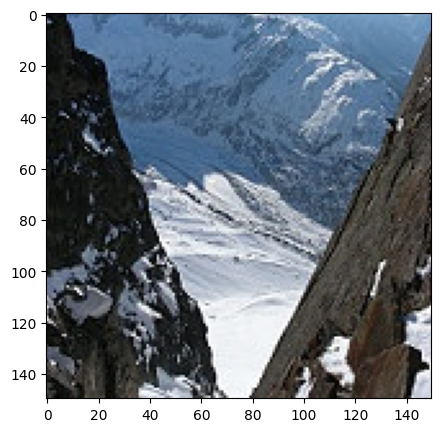

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
def show_image(path):
  image_path = os.path.join(images_path, path)
  img = Image.open(image_path)
  plt.figure(figsize=(10, 5))
  plt.imshow(img)
show_image(images[0])

In [5]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [6]:
SIZE = 160
color_img = []

In [7]:
X =[]
Y =[]

In [8]:
for path in images:
  img = os.path.join(images_path, path)
  img=cv2.imread(img,1)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #resizing image
  img = cv2.resize(img, (SIZE, SIZE))
  img = img.astype('float32') / 255.0
  Y.append(img_to_array(img))

In [9]:
for path in images:
  img = os.path.join(gray_path, path)
  img=cv2.imread(img,1)
  #resizing image
  img = cv2.resize(img, (SIZE, SIZE))
  img = img.astype('float32') / 255.0
  X.append(img_to_array(img))

In [10]:
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)

    plt.show()

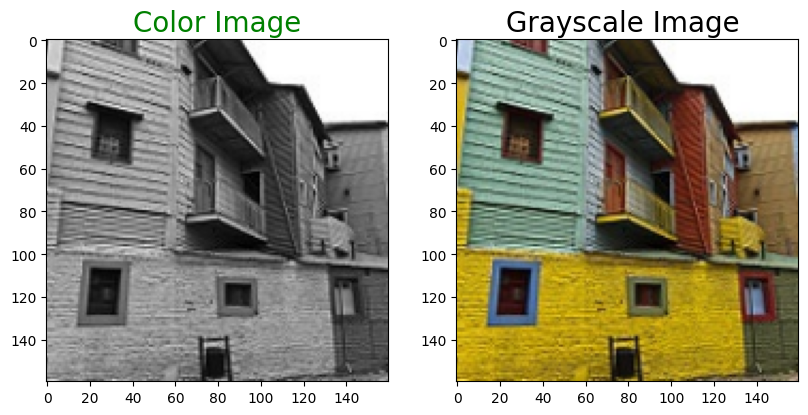

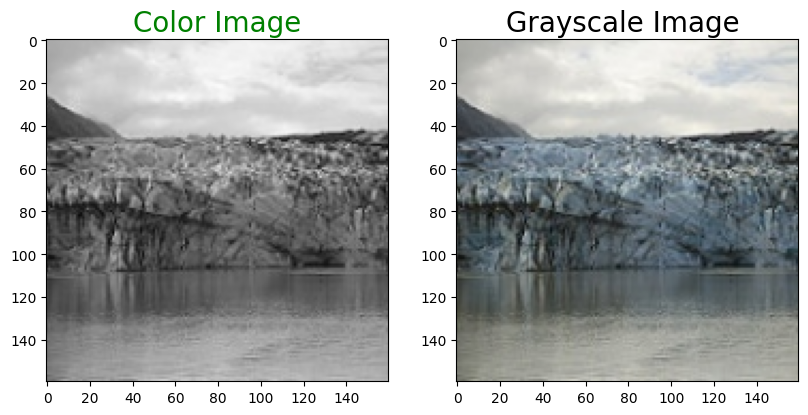

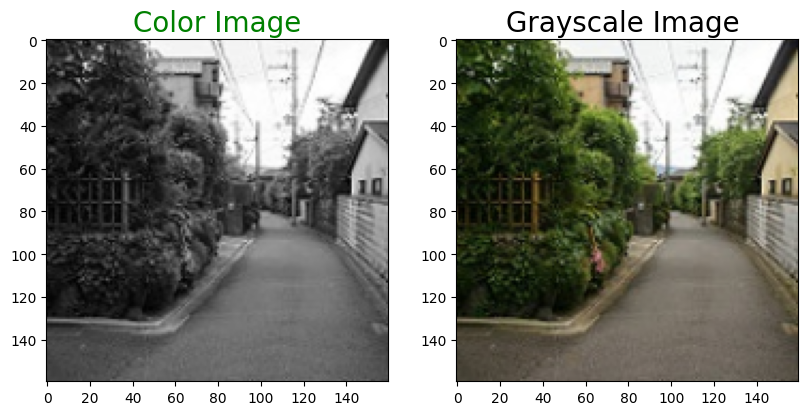

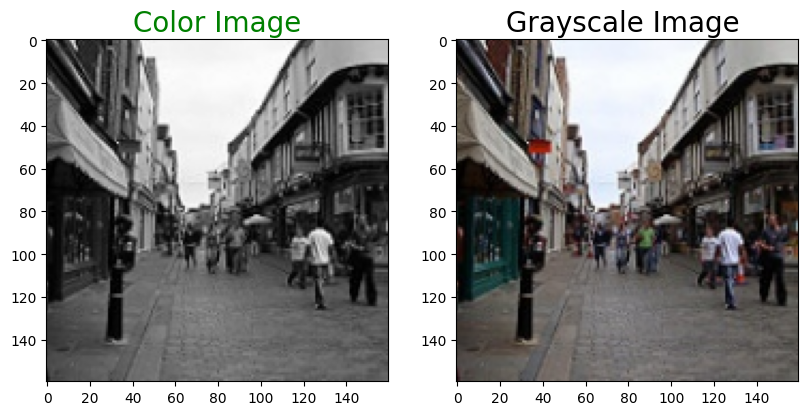

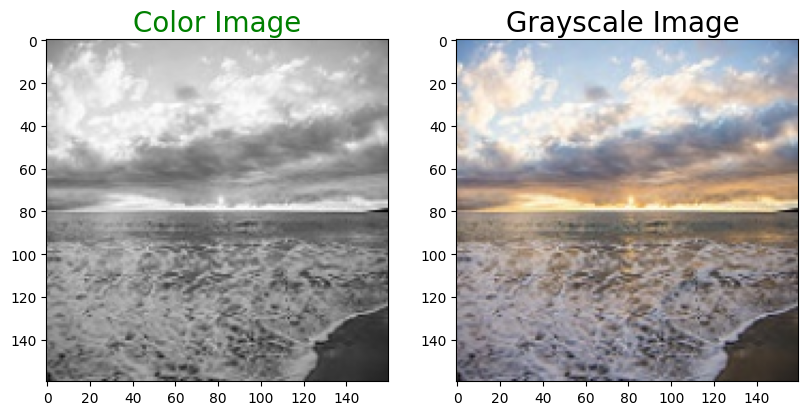

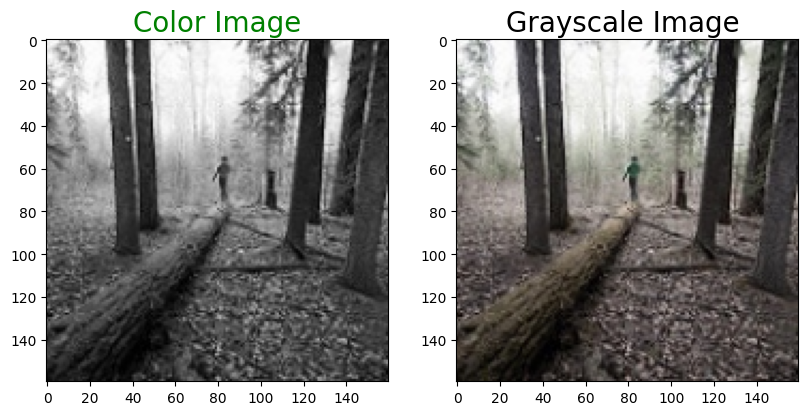

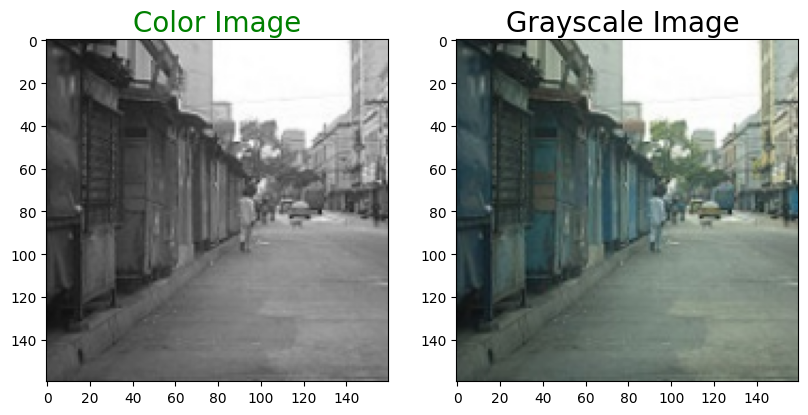

In [16]:
for i in range(3,10):
     plot_images(X[i],Y[i])

In [17]:
train_gray_image = X[:900]
train_color_image = Y[:900]

test_gray_image = X[900:]
test_color_image = Y[900:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (900, 160, 160, 3)
Test color image shape (100, 160, 160, 3)


In [18]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [19]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)

    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [20]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 80, 80, 128)          3584      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 40, 40, 128)          147584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 20, 20, 256)          296192    ['sequential_1[0][0]']        
                                                                                              

In [21]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_g, train_c, epochs = 50,batch_size = 50,verbose = 1)

Epoch 1/50
18/18 [==============================] - 21s 217ms/step - loss: 0.1716 - acc: 0.2768
Epoch 2/50
18/18 [==============================] - 4s 218ms/step - loss: 0.0957 - acc: 0.3528
Epoch 3/50
18/18 [==============================] - 4s 217ms/step - loss: 0.0905 - acc: 0.3556
Epoch 4/50
18/18 [==============================] - 4s 222ms/step - loss: 0.0852 - acc: 0.3892
Epoch 5/50
18/18 [==============================] - 4s 222ms/step - loss: 0.0797 - acc: 0.4305
Epoch 6/50
18/18 [==============================] - 4s 224ms/step - loss: 0.0783 - acc: 0.4096
Epoch 7/50
18/18 [==============================] - 4s 221ms/step - loss: 0.0736 - acc: 0.4346
Epoch 8/50
18/18 [==============================] - 4s 221ms/step - loss: 0.0701 - acc: 0.4411
Epoch 9/50
18/18 [==============================] - 4s 226ms/step - loss: 0.0671 - acc: 0.4585
Epoch 10/50
18/18 [==============================] - 4s 227ms/step - loss: 0.0649 - acc: 0.4629
Epoch 11/50
18/18 [=============================

In [22]:
model.evaluate(test_gray_image,test_color_image)

4/4 [==============================] - 3s 231ms/step - loss: 0.0539 - acc: 0.5072


[0.05391675606369972, 0.5072226524353027]

1/1 [==============================] - 0s 21ms/step


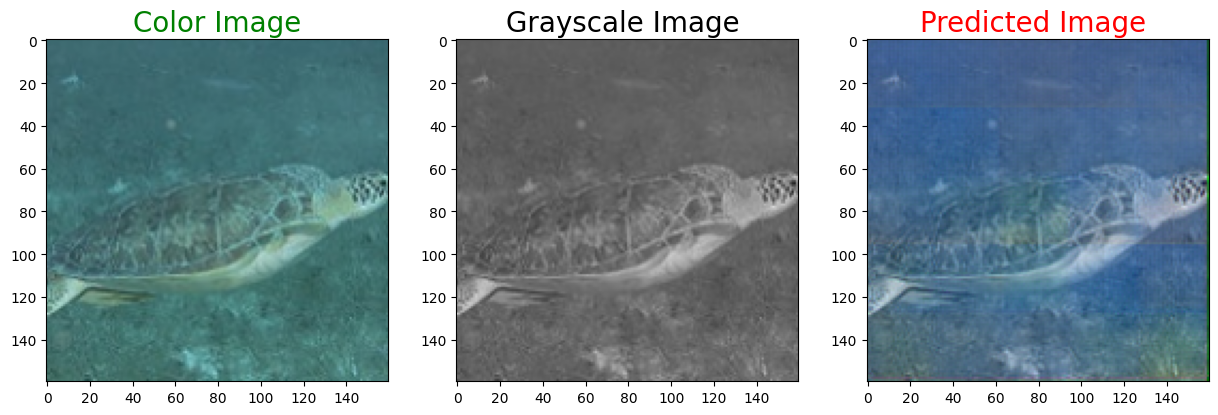

1/1 [==============================] - 0s 46ms/step


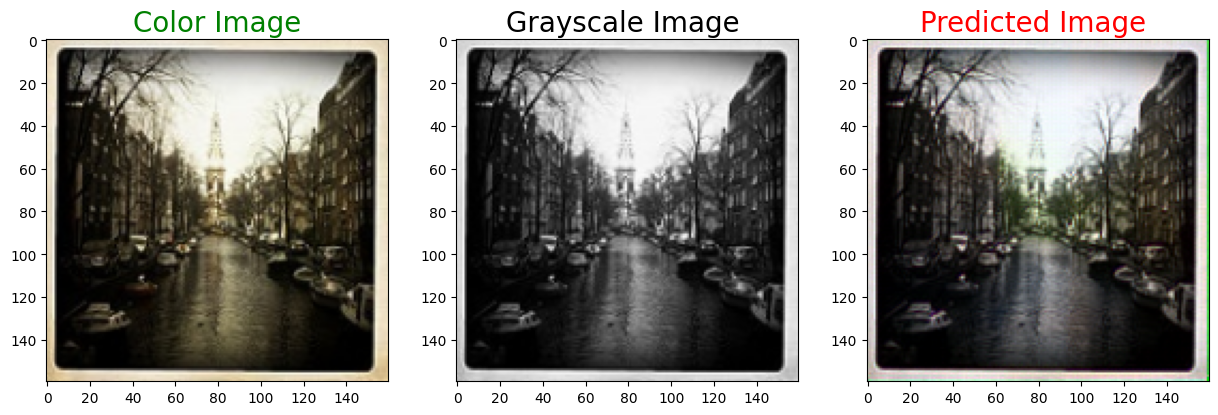

1/1 [==============================] - 0s 39ms/step


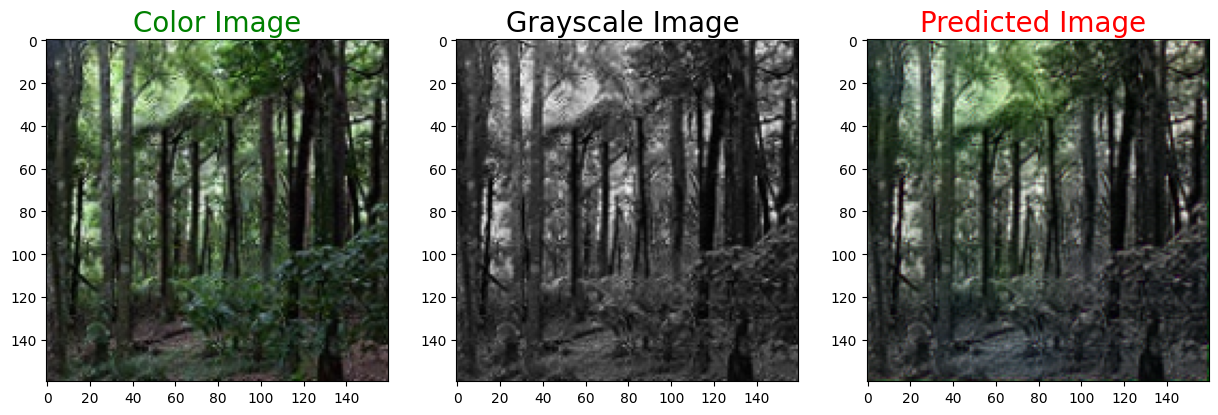

1/1 [==============================] - 0s 29ms/step


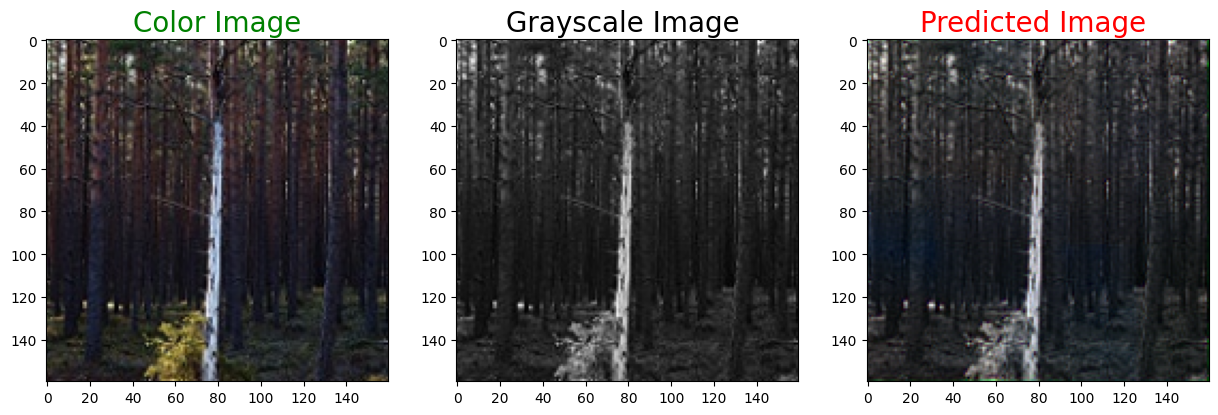

1/1 [==============================] - 0s 29ms/step


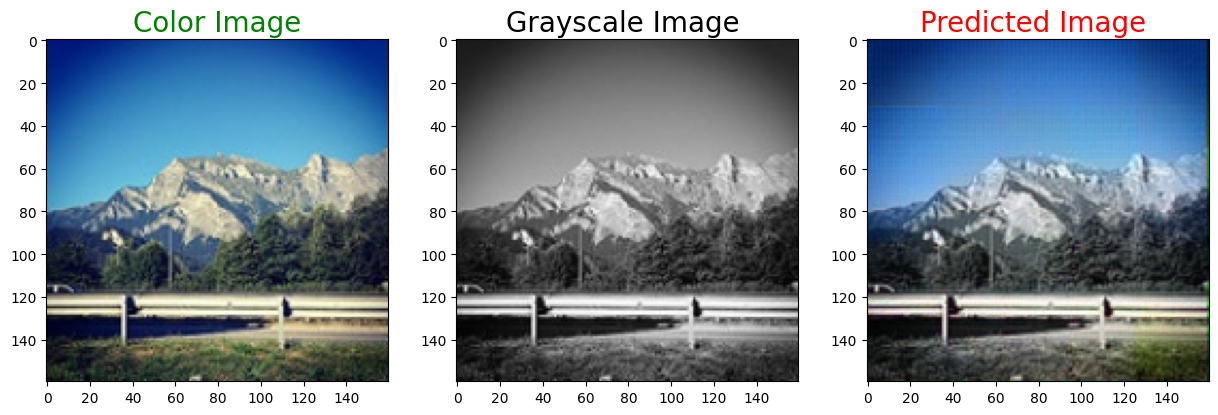

1/1 [==============================] - 0s 29ms/step


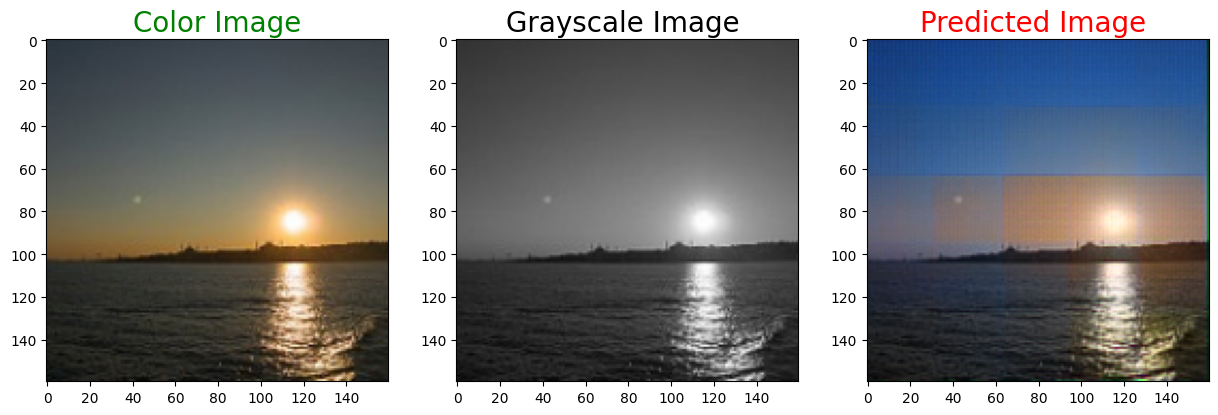

1/1 [==============================] - 0s 28ms/step


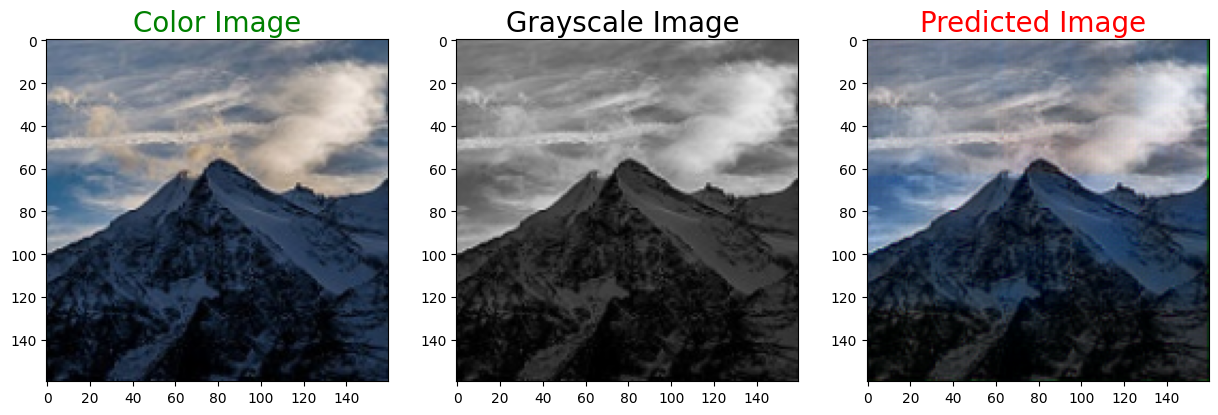

1/1 [==============================] - 0s 28ms/step


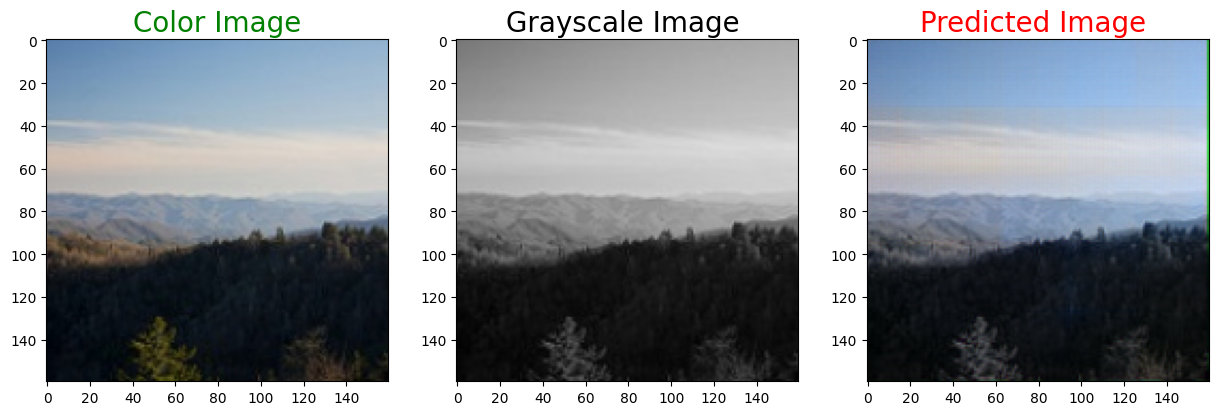

In [28]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)

    plt.show()

for i in range(50,58):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)

In [29]:
model.save('colorize_image.model')